<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LGBMRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

**Этапы проекта:**

1. Загрузить данные и выполнить их ресемплирование по одному часу
2. Проанализировать данные
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных
4. Проверить данные на тестовой выборке и сделать выводы

## Подготовка

Подключим бибилотеки, которые понадобятся для работы

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.linear_model import LinearRegression

Загрузим данные и проанализируем их

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col='datetime', parse_dates=[0])

In [3]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


ресемплируем данные по 1 часу

In [5]:
data = data.sort_index()
data = data.resample('1H').sum()

In [6]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [7]:
data.shape

(4416, 1)

**Вывод:**
- загрузили данные (данные содержат 26496 записей с количеством заказов, период с 01 марта 2018 по 31 августа 2018)
- выполнили их ресемплирование по одному часу (кол-во записей по периоду в 1 час составляет 4416 записей)

## Анализ

Добавим столбцы со скользящим средним и скользящим стандартным отклонением и построим график по данным

In [8]:
data["rolling_mean"] = data["num_orders"].rolling(10).mean()
data["rolling_std"] = data["num_orders"].rolling(10).std()

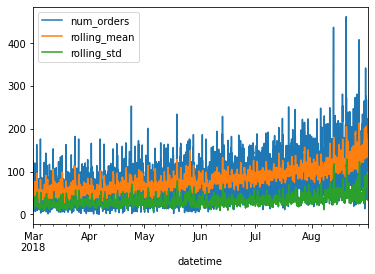

In [9]:
data.plot();

По графику можно отметить, что волатильность изменений кол-ва заказов к концу лета выше.

Построим график тренда

Text(0.5, 1.0, 'Trend')

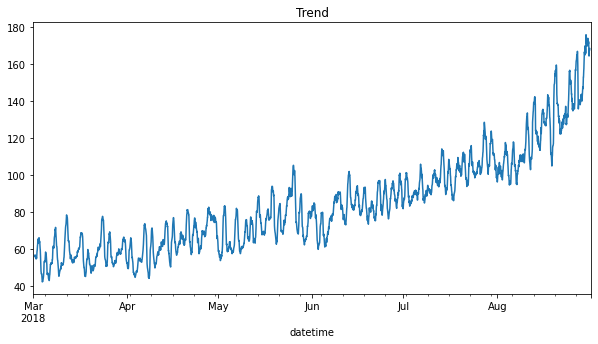

In [10]:
decomposed = seasonal_decompose(data['num_orders'])
plt.figure(figsize=(10, 5))
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

Видим линейный тренд увеличения заказов к концу лета, когда многие возвращаются из отпусков к началу учебного года

Построим графики по трем составляющим: тренду, сезонности и остатку декомпозиции в периоде одной недели августа

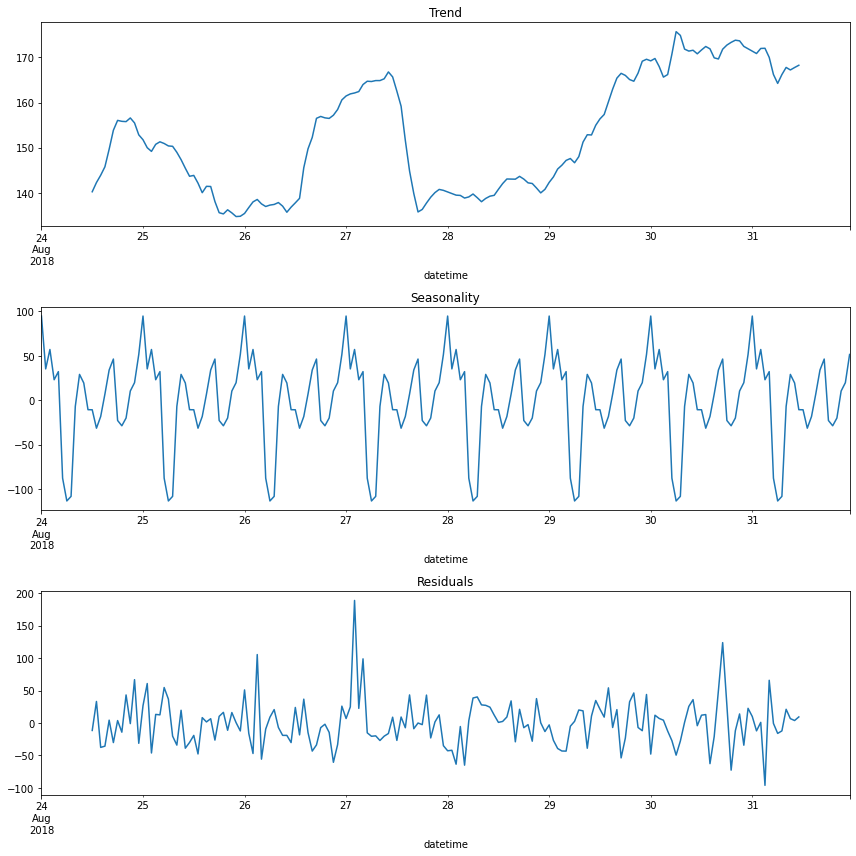

In [11]:
decomposed = seasonal_decompose(data['2018-08-24':'2018-08-31']['num_orders'])
plt.figure(figsize=(12, 12))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())

plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())

plt.title('Residuals')
plt.tight_layout()

По графику с сезонностью видим изменение в течении одного дня с наибольшим кол-ом заказов к концу дня и наименьшим ночью.

## Обучение

Напишем функцию для создания обучающих признаков. 
<br> Создадим признаки day, dayofweek, hour, признаки для скользящего среднего rolling_mean (с размером окна rolling_mean_size) и lag для признаков отстающего значения.

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [13]:
data = make_features(data, 2, 24)

выделим обучающую и тестовую выборки, с размером тестовой = 10% от данных

In [14]:
data = data.drop('rolling_std', axis = 1)

In [15]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

In [16]:
train.head()

,num_orders,rolling_mean,day,dayofweek,hour,lag_1,lag_2
datetime,,,,,,,
2018-03-02 00:00:00,90,56.833333,2,4,0,58.0,113.0
2018-03-02 01:00:00,120,55.416667,2,4,1,90.0,58.0
2018-03-02 02:00:00,75,56.875000,2,4,2,120.0,90.0
2018-03-02 03:00:00,64,57.041667,2,4,3,75.0,120.0
2018-03-02 04:00:00,20,56.958333,2,4,4,64.0,75.0


выделим в данных признаки

In [17]:
features_train = train.drop('num_orders', axis = 1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis = 1)
target_test = test['num_orders']

кросс-валидация для временного ряда

In [18]:
tscv = TimeSeriesSplit(n_splits=8)

### LinearRegression

In [19]:
lr = LinearRegression()
lr.fit(features_train, target_train)
pred_lr_train = lr.predict(features_train)
print("RMSE LinearRegression на обучающей выборке:", mean_squared_error(target_train, pred_lr_train) ** 0.5)



RMSE LinearRegression на обучающей выборке: 30.87996309066125


### RandomForestRegressor

In [20]:
tree_params = {'max_depth': [5, 12, 15, 20],
               'min_samples_split': [2, 3, 4, 5]}

In [21]:
grid_rfr = GridSearchCV(RandomForestRegressor(random_state=12345), 
                        tree_params, refit=False, cv=tscv, n_jobs=-1, scoring='neg_mean_squared_error') 
grid_rfr.fit(features_train, target_train)
params = grid_rfr.best_params_
rfr = RandomForestRegressor(**params, random_state = 12345)
rfr.fit(features_train, target_train)
pred_rfr_train = rfr.predict(features_train)
print(params)
print("RMSE RandomForestRegressor на обучающей выборке: ", mean_squared_error(target_train, pred_rfr_train) ** 0.5)


{'max_depth': 15, 'min_samples_split': 2}
RMSE RandomForestRegressor на обучающей выборке:  9.786584710529608


### LGBMRegressor

In [22]:
param_grid = {
    'n_estimators': [400], 
    'learning_rate': [0.01, 0.02, 0.15],
    'max_depth': [6, 10, 12],
    'num_leaves': [6, 12, 25]
}

In [23]:
grid_lgbm = GridSearchCV(lgb.LGBMRegressor(random_state=12345), 
                    param_grid, cv=tscv, n_jobs=-1, scoring='neg_mean_squared_error', refit=False) 
grid_lgbm.fit(features_train, target_train)
params = grid_lgbm.best_params_
lgbm = lgb.LGBMRegressor(**params, random_state = 12345)
lgbm.fit(features_train, target_train)
pred_lgbm_train = lgbm.predict(features_train)
print(params)
print("RMSE LGBMRegressor на обучающей выборке: ", mean_squared_error(target_train, pred_lgbm_train) ** 0.5)

{'learning_rate': 0.02, 'max_depth': 12, 'n_estimators': 400, 'num_leaves': 25}
RMSE LGBMRegressor на обучающей выборке:  17.801719862562326


## Тестирование

In [24]:
pred_lr_test = lr.predict(features_test)
pred_rfr_test = rfr.predict(features_test)
pred_lgbm_test = lgbm.predict(features_test)
print("RMSE LR на тестовой выборке: ", mean_squared_error(target_test, pred_lr_test, squared=False))
print("RMSE RFR на тестовой выборке: ", mean_squared_error(target_test, pred_rfr_test, squared=False))
print("RMSE LGBM на тестовой выборке: ", mean_squared_error(target_test, pred_lgbm_test, squared=False))

RMSE LR на тестовой выборке:  51.26017029472908
RMSE RFR на тестовой выборке:  47.25283831621277
RMSE LGBM на тестовой выборке:  44.89313064217499


In [25]:
true_pred = pd.DataFrame({ 
    'истинные' : target_test,
    'предсказанные' : lgbm.predict(features_test)
    })

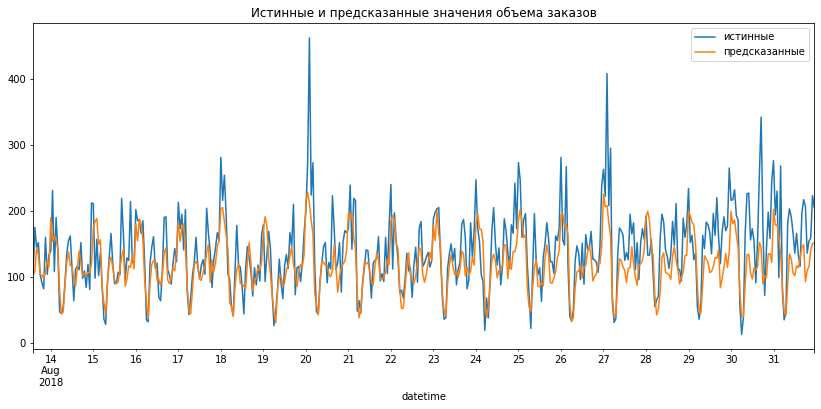

In [26]:
true_pred.plot(figsize=(14,6), title='Истинные и предсказанные значения объема заказов');

В результате предсказанные значения кол-ва заказов по модели LGBMRegressor на тестовой выборке близки к истинным данным

## Вывод

В ходе работы по прогнозированию кол-ва заказов такси было проведено:
- ресемплирование данных до 1 часа
- обнаружен растущий тренд кол-ва заказов к концу лета, что может быть связано с возвращением людей из отпусков к началу учебного года
- сезонность можно отметить только в рамках одного дня с наибольшим кол-ом заказов к концу дня и наименьшим ночью
- далее были созданы выборки (тестовая размером 10%), признаки и обучены 3 модели для предсказания количества заказов: LinearRegression, RandomForestRegressor и LGBMRegressor

<br> В результате тестирования моделей на тестовой выборке лучшее значение RMSE - 44.9 показала модель LGBMRegressor 
<br> Результат незначительно хуже - 47.3 показала модель RandomForestRegressor
<br> И худшее значение RSME - 51.3 получилось на модели  LinearRegression (значение вне допустимого по заданию)

<br> В заключении по лучшей модели (LGBMRegressor) был построен график, показывающий сравнение истинного кол-ва заказов и предсказанных на лучшей модели, именно модель LGBMRegressor рекомендуется для дальнейшего применения.